In [1]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
eeg_emo0 = np.load('Data/eeg_emo_chan.npy')
targets = np.load('Data/targets.npy')
print(eeg_emo0.shape)
print(targets.shape)

(1280, 16, 8064)
(1280, 4)


In [4]:
eeg_emo = eeg_emo0[:,:,384:] # cut 3s baseline
print(eeg_emo.shape)

(1280, 16, 7680)


# divided into 12 segments which each is 5 seconds

In [5]:
eeg_emo_5s = np.empty((eeg_emo.shape[0]*12,eeg_emo.shape[1],640))
targets_5s = np.empty((eeg_emo.shape[0]*12,4))

for i,k in enumerate(range(0,eeg_emo_5s.shape[0],12)):
    for j in range(12):
        eeg_emo_5s[k+j,:,:] = eeg_emo[i,:,640*j:640*(j+1)]
        targets_5s[k+j,:] = targets[i,:]
print(eeg_emo_5s.shape)
print(targets_5s.shape)

(15360, 16, 640)
(15360, 4)


# ฺValence

In [6]:
# valence 0-low ,1 high 
valence = []
mean_valence = np.mean(targets_5s[:,0])
for i in range(targets_5s.shape[0]):
    if targets_5s[i,0] < mean_valence :
        valence.append(0)
    else :
        valence.append(1)
valence = np.array(valence)
valence.shape

(15360,)

In [7]:
from tensorflow.keras.utils import to_categorical
valence = to_categorical(valence)
valence.shape

(15360, 2)

In [8]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,eeg_emo_5s.shape[0],1)
ts = int(train_size*eeg_emo_5s.shape[0]) 
vs = int(val_size*eeg_emo_5s.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [9]:
x_train = eeg_emo_5s[idx_train,:1,:]
x_val = eeg_emo_5s[idx_val,:1,:]
x_test = eeg_emo_5s[idx_test,:1,:]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)

print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (10752, 1, 640)
x_val (1536, 1, 640)
x_test (3072, 1, 640)
y_train (10752, 2)
y_val (1536, 2)
y_test (3072, 2)


# DataLoader

In [10]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [11]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 150
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_val, y_val), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

# LSTM

In [35]:
#model hyperparameters
hidden_dim1 = 8
embed_dim = x_train.shape[2]
output_dim = 2
num_layers = 1
bidirectional = True
dropout = 0.5

#training hyperparameters
num_epochs =100
lr=0.0001

In [36]:
import torch.nn as nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 4 , 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5))      
        self.lstm = nn.LSTM(319, hidden_dim1, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim1*2, output_dim)   
        self.fc1 = nn.Linear(15356, output_dim)
    
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        #out0 = out0.reshape(out0.size(0), -1)
        return self.fc(attn_output)

In [37]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [38]:
model = LSTM().cuda(3)
#model.apply(initialize_weights)

In [39]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)

# Train Test 

In [40]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/2

In [41]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)
    return acc

In [42]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(3)
        label = label.cuda(3)
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [43]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(3)
            label = label.cuda(3)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [44]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    if epoch%50==0:
        
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 1.570 | Train Acc: 48.90%
	 Val. Loss: 0.707 |  Val. Acc: 45.90%
Epoch: 51 | Train Loss: 0.917 | Train Acc: 52.45%
	 Val. Loss: 0.691 |  Val. Acc: 54.15%


Text(0, 0.5, 'loss')

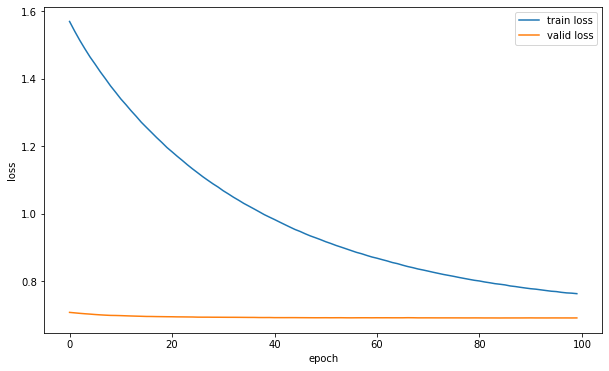

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

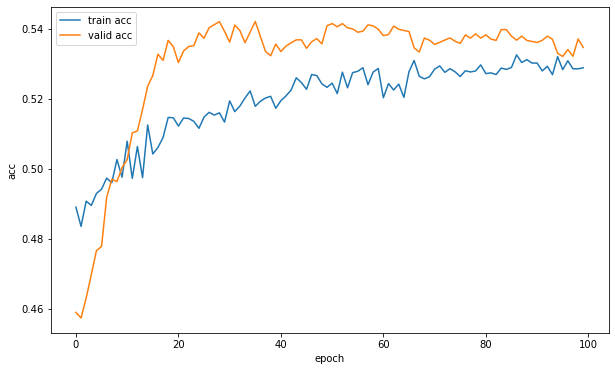

In [46]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

In [47]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.690 | Test Acc: 54.03%
